##### Copyright 2018 The TensorFlow Authors.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Hub with Keras

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/images/hub_with_keras"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/images/hub_with_keras.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/images/hub_with_keras.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

[TensorFlow Hub](http://tensorflow.org/hub) is a way to share pretrained model components. See the [TensorFlow Module Hub](https://tfhub.dev/) for a searchable listing of pre-trained models.

This tutorial demonstrates:

1. How to use TensorFlow Hub with `tf.keras`.
1. How to do image classification using TensorFlow Hub.
1. How to do simple transfer learning.

## Setup

### Imports

In [ ]:
#!pip install --force tensorflow
!pip install --force tensorflow_hub

In [3]:
from __future__ import absolute_import, division, print_function

import matplotlib.pylab as plt

import tensorflow as tf
import tensorflow_hub as hub

from tensorflow.keras import layers

tf.VERSION

'1.13.1'

### Dataset

 For this example we'll use the TensorFlow flowers dataset: 

In [4]:
data_root = tf.keras.utils.get_file(
  'flower_photos','https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
   untar=True)

The simplest way to load this data into our model is using `tf.keras.preprocessing.image.ImageDataGenerator`:

All of TensorFlow Hub's image modules expect float inputs in the `[0, 1]` range. Use the `ImageDataGenerator`'s `rescale` parameter to achieve this. 

The image size will be handles later.

In [5]:
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255)
image_data = image_generator.flow_from_directory(str(data_root))

Found 3670 images belonging to 5 classes.


The resulting object is an iterator that returns `image_batch, label_batch` pairs.

In [6]:
for image_batch,label_batch in image_data:
  print("Image batch shape: ", image_batch.shape)
  print("Labe batch shape: ", label_batch.shape)
  break

Image batch shape:  (32, 256, 256, 3)
Labe batch shape:  (32, 5)


## An ImageNet classifier

### Download the classifier

Use `hub.module` to load a mobilenet, and `tf.keras.layers.Lambda` to wrap it up as a keras layer.

Any [image classifier url from tfhub.dev](https://tfhub.dev/s?module-type=image-classification) will work here.

In [7]:
classifier_url = "https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/classification/2" #@param {type:"string"}

In [8]:
def classifier(x):
  classifier_module = hub.Module(classifier_url)
  return classifier_module(x)
  
IMAGE_SIZE = hub.get_expected_image_size(hub.Module(classifier_url))

Instructions for updating:
Colocations handled automatically by placer.


W0306 07:22:22.330385 140625452795264 deprecation.py:323] From /User/.pythonlibs/lib/python3.6/site-packages/tensorflow/python/ops/control_flow_ops.py:3632: colocate_with (from tensorflow.python.framework.ops) is deprecated and will be removed in a future version.
Instructions for updating:
Colocations handled automatically by placer.


In [9]:
classifier_layer = layers.Lambda(classifier, input_shape = IMAGE_SIZE+[3])
classifier_model = tf.keras.Sequential([classifier_layer])
classifier_model.summary()

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0306 07:22:35.723144 140625452795264 saver.py:1483] Saver not created because there are no variables in the graph to restore


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda (Lambda)              (None, 1001)              0         
Total params: 0
Trainable params: 0
Non-trainable params: 0
_________________________________________________________________


Rebuild the data generator, with the output size set to match what's expected by the module.

In [10]:
image_data = image_generator.flow_from_directory(str(data_root), target_size=IMAGE_SIZE)
for image_batch,label_batch in image_data:
  print("Image batch shape: ", image_batch.shape)
  print("Labe batch shape: ", label_batch.shape)
  break

Found 3670 images belonging to 5 classes.
Image batch shape:  (32, 224, 224, 3)
Labe batch shape:  (32, 5)


When using Keras, TFHub modules need to be manually initialized.

In [11]:
import tensorflow.keras.backend as K
sess = K.get_session()
init = tf.global_variables_initializer()

sess.run(init)

### Run it on a single image

Download a single image to try the model on.

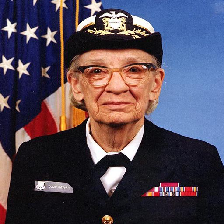

In [12]:
import numpy as np
import PIL.Image as Image

grace_hopper = tf.keras.utils.get_file('image.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/grace_hopper.jpg')
grace_hopper = Image.open(grace_hopper).resize(IMAGE_SIZE)
grace_hopper 

In [13]:
grace_hopper = np.array(grace_hopper)/255.0
grace_hopper.shape

(224, 224, 3)

Add a batch dimension, and pass the image to the model.

In [14]:
result = classifier_model.predict(grace_hopper[np.newaxis, ...])
result.shape


(1, 1001)

The result is a 1001 element vector of logits, rating the probability of each class for the image.

So the top class ID can be found with argmax:

In [15]:
predicted_class = np.argmax(result[0], axis=-1)
predicted_class

653

### Decode the predictions

We have the predicted class ID, 
Fetch the `ImageNet` labels, and decode the predictions

In [16]:
labels_path = tf.keras.utils.get_file('ImageNetLabels.txt','https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
imagenet_labels = np.array(open(labels_path).read().splitlines())

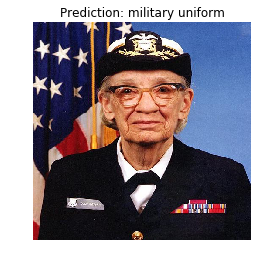

In [17]:
plt.imshow(grace_hopper)
plt.axis('off')
predicted_class_name = imagenet_labels[predicted_class]
_ = plt.title("Prediction: " + predicted_class_name)

### Run it on a batch of images

Now run the classifier on the image batch.

In [18]:
result_batch = classifier_model.predict(image_batch)

In [19]:
labels_batch = imagenet_labels[np.argmax(result_batch, axis=-1)]
labels_batch

array(['daisy', 'bee', 'stone wall', 'cardoon', 'barn spider',
       'picket fence', 'daisy', 'coral fungus', 'rapeseed',
       'picket fence', 'American egret', 'daisy', 'coral fungus',
       'jinrikisha', 'daisy', 'strawberry', 'cardoon', 'admiral', 'daisy',
       'rapeseed', 'daisy', 'hip', 'bee', 'quill', 'vase', 'handkerchief',
       'matchstick', 'mushroom', 'pretzel', 'daisy', 'daisy', 'orange'],
      dtype='<U30')

Now check how these predictions line up with the images:

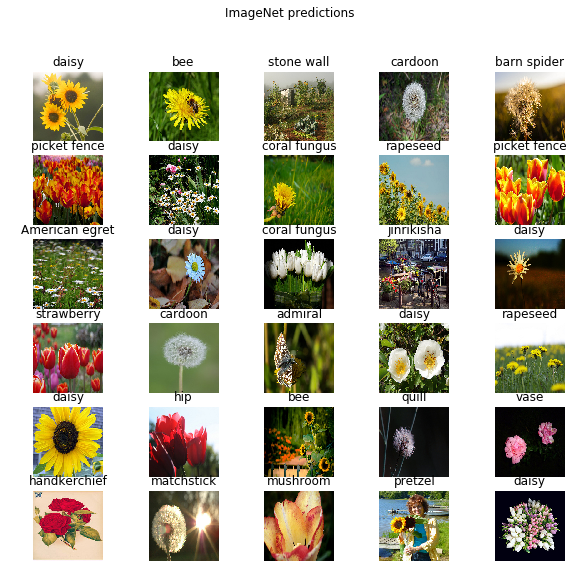

In [20]:
plt.figure(figsize=(10,9))
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch[n])
  plt.title(labels_batch[n])
  plt.axis('off')
_ = plt.suptitle("ImageNet predictions")

See the `LICENSE.txt` file for image attributions.

The results are far from perfect, but reasonable considering that these are not the classes the model was trained for (except "daisy").

## Simple transfer learning

Using tfhub it is simple to retrain the top layer of the model to recognize the classes in our dataset.

### Download the headless model

TensorFlow Hub also distributes models without the top classification layer. These can be used to easily do transfer learning.

Any [image feature vector url from tfhub.dev](https://tfhub.dev/s?module-type=image-feature-vector) will work here.

In [21]:
feature_extractor_url = "https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/2" #@param {type:"string"}

Create the module, and check the expected image size:

In [22]:
def feature_extractor(x):
  feature_extractor_module = hub.Module(feature_extractor_url)
  return feature_extractor_module(x)

IMAGE_SIZE = hub.get_expected_image_size(hub.Module(feature_extractor_url))

Ensure the data generator is generating images of the expected size:

In [23]:
image_data = image_generator.flow_from_directory(str(data_root), target_size=IMAGE_SIZE)
for image_batch,label_batch in image_data:
  print("Image batch shape: ", image_batch.shape)
  print("Labe batch shape: ", label_batch.shape)
  break

Found 3670 images belonging to 5 classes.
Image batch shape:  (32, 224, 224, 3)
Labe batch shape:  (32, 5)


Wrap the module in a keras layer.

In [24]:
features_extractor_layer = layers.Lambda(feature_extractor, input_shape=IMAGE_SIZE+[3])

Freeze the variables in the feature extractor layer, so that the training only modifies the new classifier layer.

In [25]:
features_extractor_layer.trainable = False

### Attach a classification head

Now wrap the hub layer in a `tf.keras.Sequential` model, and add a new classification layer.

In [26]:
model = tf.keras.Sequential([
  features_extractor_layer,
  layers.Dense(image_data.num_classes, activation='softmax')
])
model.summary()

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0306 07:23:23.134701 140625452795264 saver.py:1483] Saver not created because there are no variables in the graph to restore


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_1 (Lambda)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 5)                 6405      
Total params: 6,405
Trainable params: 6,405
Non-trainable params: 0
_________________________________________________________________


Initialize the TFHub module.

In [27]:
init = tf.global_variables_initializer()
sess.run(init)

Test run a single batch, to see that the result comes back with the expected shape.

In [28]:
result = model.predict(image_batch)
result.shape

(32, 5)

### Train the model

Use compile to configure the training process:

In [29]:
model.compile(
  optimizer=tf.train.AdamOptimizer(), 
  loss='categorical_crossentropy',
  metrics=['accuracy'])

Now use the `.fit` method to train the model.

To keep this example short train just a single epoch. To visualize the training progress during that epoch, use a custom callback to log the loss and accuract of each batch. 

In [30]:
class CollectBatchStats(tf.keras.callbacks.Callback):
  def __init__(self):
    self.batch_losses = []
    self.batch_acc = []
    
  def on_batch_end(self, batch, logs=None):
    self.batch_losses.append(logs['loss'])
    self.batch_acc.append(logs['acc'])

In [31]:
steps_per_epoch = image_data.samples//image_data.batch_size
batch_stats = CollectBatchStats()
model.fit((item for item in image_data), epochs=1, 
                    steps_per_epoch=steps_per_epoch,
                    callbacks = [batch_stats])

Instructions for updating:
Use tf.cast instead.


W0306 07:24:02.074383 140625452795264 deprecation.py:323] From /User/.pythonlibs/lib/python3.6/site-packages/tensorflow/python/ops/math_ops.py:3066: to_int32 (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.cast instead.


114/114 [==============================] - 102s 898ms/step - loss: 0.6676 - acc: 0.7589


Now after, even just a few training iterations, we can already see that the model is making progress on the task.

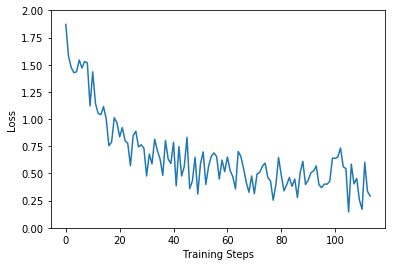

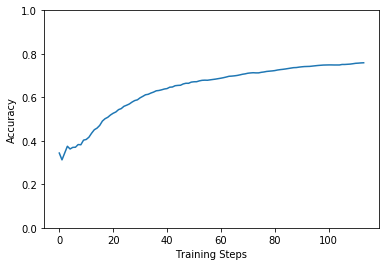

In [32]:
plt.figure()
plt.ylabel("Loss")
plt.xlabel("Training Steps")
plt.ylim([0,2])
plt.plot(batch_stats.batch_losses)

plt.figure()
plt.ylabel("Accuracy")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(batch_stats.batch_acc)


### Check the predictions

To redo the plot from before, first get the ordered list of class names:

In [33]:
label_names = sorted(image_data.class_indices.items(), key=lambda pair:pair[1])
label_names = np.array([key.title() for key, value in label_names])
label_names

array(['Daisy', 'Dandelion', 'Roses', 'Sunflowers', 'Tulips'],
      dtype='<U10')

Run the image batch through the model and comvert the indices to class names.

In [34]:
result_batch = model.predict(image_batch)

labels_batch = label_names[np.argmax(result_batch, axis=-1)]
labels_batch

array(['Roses', 'Dandelion', 'Roses', 'Dandelion', 'Daisy', 'Roses',
       'Sunflowers', 'Tulips', 'Tulips', 'Roses', 'Tulips', 'Sunflowers',
       'Tulips', 'Daisy', 'Dandelion', 'Dandelion', 'Dandelion', 'Daisy',
       'Roses', 'Roses', 'Sunflowers', 'Daisy', 'Tulips', 'Daisy',
       'Daisy', 'Dandelion', 'Roses', 'Sunflowers', 'Daisy', 'Sunflowers',
       'Roses', 'Dandelion'], dtype='<U10')

Plot the result

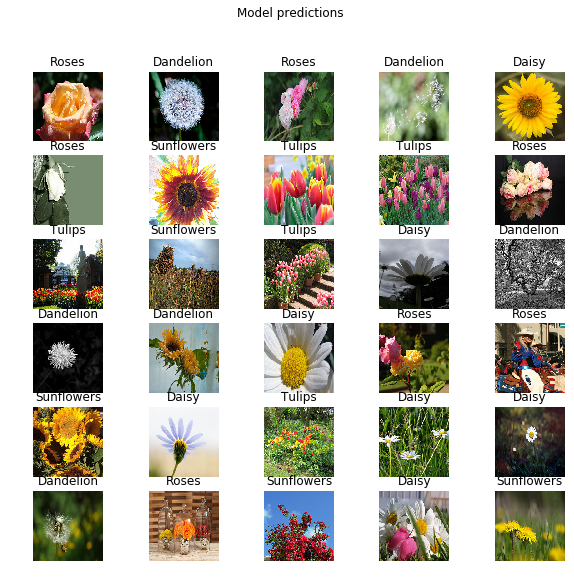

In [35]:
plt.figure(figsize=(10,9))
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch[n])
  plt.title(labels_batch[n])
  plt.axis('off')
_ = plt.suptitle("Model predictions")

## Export your model

Now that you've trained the model, export it as a saved model:

In [36]:
export_path = tf.contrib.saved_model.save_keras_model(model, "./saved_models")
export_path


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Use tf.train.CheckpointManager to manage checkpoints rather than manually editing the Checkpoint proto.


W0306 07:27:13.718866 140625452795264 deprecation.py:323] From /User/.pythonlibs/lib/python3.6/site-packages/tensorflow/python/keras/engine/network.py:1436: update_checkpoint_state (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.train.CheckpointManager to manage checkpoints rather than manually editing the Checkpoint proto.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0306 07:27:16.437299 140625452795264 saver.py:1483] Saver not created because there are no variables in the graph to restore


Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.utils.build_tensor_info or tf.compat.v1.saved_model.build_tensor_info.


W0306 07:27:18.383784 140625452795264 deprecation.py:323] From /User/.pythonlibs/lib/python3.6/site-packages/tensorflow/python/saved_model/signature_def_utils_impl.py:257: build_tensor_info (from tensorflow.python.saved_model.utils_impl) is deprecated and will be removed in a future version.
Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.utils.build_tensor_info or tf.compat.v1.saved_model.build_tensor_info.


INFO:tensorflow:Signatures INCLUDED in export for Classify: None


I0306 07:27:18.385218 140625452795264 export.py:587] Signatures INCLUDED in export for Classify: None


INFO:tensorflow:Signatures INCLUDED in export for Regress: None


I0306 07:27:18.386342 140625452795264 export.py:587] Signatures INCLUDED in export for Regress: None


INFO:tensorflow:Signatures INCLUDED in export for Predict: None


I0306 07:27:18.387410 140625452795264 export.py:587] Signatures INCLUDED in export for Predict: None


INFO:tensorflow:Signatures INCLUDED in export for Train: ['train']


I0306 07:27:18.389684 140625452795264 export.py:587] Signatures INCLUDED in export for Train: ['train']


INFO:tensorflow:Signatures INCLUDED in export for Eval: None


I0306 07:27:18.390678 140625452795264 export.py:587] Signatures INCLUDED in export for Eval: None


W0306 07:27:18.391569 140625452795264 tf_logging.py:161] Export includes no default signature!


INFO:tensorflow:No assets to save.


I0306 07:27:18.969140 140625452795264 builder_impl.py:629] No assets to save.


INFO:tensorflow:No assets to write.


I0306 07:27:18.970280 140625452795264 builder_impl.py:124] No assets to write.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0306 07:27:21.718162 140625452795264 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Signatures INCLUDED in export for Classify: None


I0306 07:27:22.752938 140625452795264 export.py:587] Signatures INCLUDED in export for Classify: None


INFO:tensorflow:Signatures INCLUDED in export for Regress: None


I0306 07:27:22.754033 140625452795264 export.py:587] Signatures INCLUDED in export for Regress: None


INFO:tensorflow:Signatures INCLUDED in export for Predict: None


I0306 07:27:22.754847 140625452795264 export.py:587] Signatures INCLUDED in export for Predict: None


INFO:tensorflow:Signatures INCLUDED in export for Train: None


I0306 07:27:22.755618 140625452795264 export.py:587] Signatures INCLUDED in export for Train: None


INFO:tensorflow:Signatures INCLUDED in export for Eval: ['eval']


I0306 07:27:22.756500 140625452795264 export.py:587] Signatures INCLUDED in export for Eval: ['eval']


W0306 07:27:22.757278 140625452795264 tf_logging.py:161] Export includes no default signature!


INFO:tensorflow:No assets to save.


I0306 07:27:23.194642 140625452795264 builder_impl.py:629] No assets to save.


INFO:tensorflow:No assets to write.


I0306 07:27:23.195883 140625452795264 builder_impl.py:124] No assets to write.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0306 07:27:26.045495 140625452795264 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Signatures INCLUDED in export for Classify: None


I0306 07:27:26.891401 140625452795264 export.py:587] Signatures INCLUDED in export for Classify: None


INFO:tensorflow:Signatures INCLUDED in export for Regress: None


I0306 07:27:26.892790 140625452795264 export.py:587] Signatures INCLUDED in export for Regress: None


INFO:tensorflow:Signatures INCLUDED in export for Predict: ['serving_default']


I0306 07:27:26.893529 140625452795264 export.py:587] Signatures INCLUDED in export for Predict: ['serving_default']


INFO:tensorflow:Signatures INCLUDED in export for Train: None


I0306 07:27:26.894267 140625452795264 export.py:587] Signatures INCLUDED in export for Train: None


INFO:tensorflow:Signatures INCLUDED in export for Eval: None


I0306 07:27:26.895145 140625452795264 export.py:587] Signatures INCLUDED in export for Eval: None


INFO:tensorflow:No assets to save.


I0306 07:27:27.324883 140625452795264 builder_impl.py:629] No assets to save.


INFO:tensorflow:No assets to write.


I0306 07:27:27.327010 140625452795264 builder_impl.py:124] No assets to write.


INFO:tensorflow:SavedModel written to: ./saved_models/1551857232/saved_model.pb


I0306 07:27:27.847389 140625452795264 builder_impl.py:414] SavedModel written to: ./saved_models/1551857232/saved_model.pb


b'./saved_models/1551857232'

This saved model can loaded for inference later, or converted to [TFLite](https://www.tensorflow.org/lite/convert/) or [TFjs](https://github.com/tensorflow/tfjs-converter).

